In [1]:
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 36.0 MB/s eta 0:00:00


# Land Use Land Cover Classification for Murang'a 2024.
### analysis was done for the period of December 2024 - January 2024.
 Code written in Python and I used multiple libraries for this script such as GeoPandas and pandas to load the vector file/database and plot it, Rasterio to load and handle raster data, Scikit-learn to do machine learning, Xgboost for machine learning,Matplotlib of course to plot, Numpy  for raster/array manipulation, PIL for showing raster data, Scikit-image for image segmentation, and SciPy for statistics analysis

In [2]:
# Import required Libraries

import os
import numpy as np
import geopandas as gpd
import rasterio
from rasterio.windows import Window
from rasterio.plot import show
from rasterio.transform import from_origin
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score,accuracy_score, cohen_kappa_score,ConfusionMatrixDisplay
from sklearn.inspection import PartialDependenceDisplay
import seaborn as sns
import pandas as pd
from tqdm import tqdm
import joblib
import warnings
from shapely.geometry import box
from sklearn.preprocessing import StandardScaler
from skimage.exposure import rescale_intensity
from skimage import segmentation, color
from skimage.util import img_as_float

In [3]:

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# set the output directory
output_dir = '/content/drive/MyDrive/MurangaCropTypeTests/outputs'
os.makedirs(output_dir, exist_ok=True)

# Load training data from shapefile
print("Loading training data from shapefile...")
train_shapefile = "/content/drive/MyDrive/MurangaCropTypeTests/data/final_training_points.shp"
gdf = gpd.read_file(train_shapefile)

# Print available columns in the shapefile
print("\nAvailable columns in training shapefile:")
print(gdf.columns)

# set column contains the labels
label_column = 'class'
features = gdf.drop(columns=[label_column, 'geometry'])

# Print training features statistics
print("\nTraining features statistics: \n -----------------")
print(features.describe())

# Load and process the multiband TIFF image
image_path = "/content/drive/MyDrive/MurangaImage/MurangaImagefull.tif"

# Define band indices
BAND_INDICES = {
    'blue': 2,
    'green': 3,
    'red': 4,
    'nir': 8,
    'swir': 11,
    'vv': 12,
    'vh': 13
}


Loading training data from shapefile...

Available columns in training shapefile:
Index(['class', 'name', 'layer', 'path', 'geometry'], dtype='object')

Training features statistics: 
 -----------------
              name                          layer  \
count         8608                           8608   
unique           6                              2   
top     Vegetation  final_training_points_stephen   
freq          2741                           4939   

                                                path  
count                                           8608  
unique                                             2  
top     E:/StephenMutwiwa2/final_training_points.shp  
freq                                            4939  


### part 2
open the raster image and check if it is spatially correct and the clip the training points to make sure they all fall under the Area of Interest.



Number of training points within raster extent: 8601


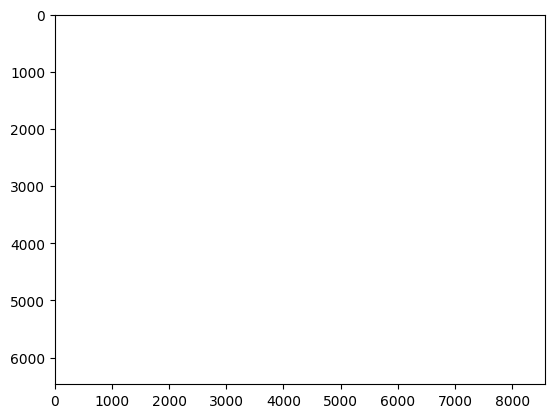

In [4]:
# Open raster to get bounds and CRS
with rasterio.open(image_path) as src:
    raster_bounds = src.bounds
    raster_crs = src.crs
    raster_box = box(*raster_bounds)
    img = src.read([4, 3, 2])

def contrast_stretch(band):
    p2 = np.percentile(band, 2)
    p98 = np.percentile(band, 98)
    return np.clip((band - p2) / (p98 - p2), 0, 1)

stretched = np.array([contrast_stretch(img[i]) for i in range(3)])
plt.imshow(np.transpose(stretched, (1, 2, 0)))

# Ensure the GeoDataFrame is in the same CRS as the raster
if gdf.crs != raster_crs:
    gdf = gdf.to_crs(raster_crs)

# Filter points that intersect with the raster extent
gdf = gdf[gdf.intersects(raster_box)]

print(f"\nNumber of training points within raster extent: {len(gdf)}")



In [5]:

# Performance monitoring part

def evaluate_model(y_true, y_pred, model_name, class_names=None, output_dir='./output'):
    """
    Calculate metrics and plot confusion matrix
    Args:
        y_true: True labels
        y_pred: Predicted labels
        model_name: Name for saving files
        class_names: List of class names (optional)
        output_dir: Output directory
    Returns:
        Dictionary containing evaluation metrics
    """
    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    kappa = cohen_kappa_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)
    class_names = ['Water','Vegetation','Crop','Built-up','Bareland','Grasslands']
    # Create metrics dictionary
    metrics = {
        'accuracy': accuracy,
        'kappa': kappa,
        'confusion_matrix': cm
    }

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix - {model_name}\nAccuracy: {accuracy:.2f}, Kappa: {kappa:.2f}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()

    # Save plot
    os.makedirs(output_dir, exist_ok=True)
    plt.savefig(f'{output_dir}/confusion_matrix_{model_name}.png', dpi=300)
    plt.close()
    # 1. Evaluation
    print("Evaluation on test points:\n")
    print(classification_report(y_true, y_pred))
    print(f"Overall Accuracy: {accuracy_score(y_true, y_pred):.4f}")

    display = ConfusionMatrixDisplay(cm)
    display.plot()

    return metrics

In [6]:

# Function to calculate vegetation indices
def calculate_indices(pixel_values):
    # Extract bands
    blue = pixel_values[BAND_INDICES['blue'] - 1]
    green = pixel_values[BAND_INDICES['green'] - 1]
    red = pixel_values[BAND_INDICES['red'] - 1]
    nir = pixel_values[BAND_INDICES['nir'] - 1]
    swir = pixel_values[BAND_INDICES['swir'] - 1]
    vv = pixel_values[BAND_INDICES['vv'] - 1]
    vh = pixel_values[BAND_INDICES['vh'] - 1]

    eps = 1e-10
    ndvi = (nir - red) / (nir + red + eps)
    gci = (nir / (green + eps)) - 1
    npci = (red - blue) / (red + blue + eps)
    gndvi = (nir - green) / (nir + green + eps)

    a = 2 * nir + 1
    b = a**2 - 8 * (nir - red)
    b_safe = np.maximum(b, 0)
    msavi = (a - np.sqrt(b_safe)) / 2

    return {
        'blue': blue,
        'green': green,
        'red': red,
        'nir': nir,
        'swir': swir,
        'ndvi': ndvi,
        'gci': gci,
        'npci': npci,
        'gndvi': gndvi,
        'msavi': msavi,
        'vv': vv,
        'vh': vh,
    }


In [7]:
# Function to extract features for training
def extract_features(coords, raster_path):
    """Extract pixel values and calculate indices from raster at given coordinates"""
    with rasterio.open(raster_path) as src:
        py, px = src.index(coords.x, coords.y)

        # Safety check: make sure window is within image bounds
        if (px < 0 or py < 0 or px >= src.width or py >= src.height):
            return [1e-6] * len(BAND_INDICES)  # Return dummy features

        # Read and extract band values using band indices
        try:
            blue = np.nan_to_num(src.read(BAND_INDICES['blue'], window=Window(px, py, 1, 1))[0, 0], nan=1e-6)
            green = np.nan_to_num(src.read(BAND_INDICES['green'], window=Window(px, py, 1, 1))[0, 0], nan=1e-6)
            red = np.nan_to_num(src.read(BAND_INDICES['red'], window=Window(px, py, 1, 1))[0, 0], nan=1e-6)
            nir = np.nan_to_num(src.read(BAND_INDICES['nir'], window=Window(px, py, 1, 1))[0, 0], nan=1e-6)
            swir = np.nan_to_num(src.read(BAND_INDICES['swir'], window=Window(px, py, 1, 1))[0, 0], nan=1e-6)

            vv_db = src.read(BAND_INDICES['vv'], window=Window(px, py, 1, 1))[0, 0]
            vh_db = src.read(BAND_INDICES['vh'], window=Window(px, py, 1, 1))[0, 0]
            vv = vv_db
            vh = vh_db
        except IndexError:
            return [1e-6] * len(BAND_INDICES)

        # Add VV/VH ratio for better feature separation
        vv_vh_ratio = vv / vh if vh != 0 else 1e6
        # return [blue, green, red, nir, swir, vv, vh]

        # Calculate vegetation indices
        eps = 1e-10
        ndvi = (nir - red) / (nir + red + eps)
        gci = (nir / (green + eps)) - 1
        npci = (red - blue) / (red + blue + eps)
        gndvi = (nir - green) / (nir + green + eps)
        a = 2 * nir + 1
        b = a**2 - 8 * (nir - red)
        msavi = (a - np.sqrt(np.maximum(b, 0))) / 2

        # Combine all features into a single array
        feature_vector = np.array([
            blue,       # Band 2 (Blue)
            green,      # Band 3 (Green)
            red,        # Band 4 (Red)
            nir,        # Band 8 (NIR)
            swir,       # Band 11 (SWIR)
            ndvi,       # NDVI index
            gci,        # GCI index
            npci,       # NPCI index
            gndvi,      # GNDVI index
            msavi ,      # MSAVI index
            vv,         # VV polarization
            vh,         # VH polarization
            vv_vh_ratio
        ])

        return feature_vector


In [8]:
# Function to create a consecutive order of labels as XGBoost uses the computer number system (0,1,2,3...)
def create_consecutive_labels(y):
    """
    Map existing class labels to consecutive integers starting from 0.

    Args:
        y: Array of original class labels

    Returns:
        Tuple of (new_labels, label_mapping) where:
        - new_labels: Array with consecutive labels (0, 1, 2,...)
        - label_mapping: Dictionary mapping original labels to new labels
    """
    unique_labels = np.unique(y)
    label_mapping = {orig_label: new_label for new_label, orig_label in enumerate(unique_labels)}
    new_labels = np.array([label_mapping[orig_label] for orig_label in y])

    # Print mapping for reference
    print("Label mapping:")
    for orig, new in label_mapping.items():
        print(f"Original class {orig} → New class {new}")

    return new_labels, label_mapping


Extracting features for training points...


100%|██████████| 8601/8601 [08:47<00:00, 16.30it/s]


Adjusted class labels: [0 1 2 3 4 5]

Feature statistics:
           blue_b2     green_b3       red_b4       nir_b8         swir  \
count  8601.000000  8601.000000  8601.000000  8601.000000  8601.000000   
mean      0.036116     0.058507     0.054946     0.267795     0.165219   
std       0.032455     0.035020     0.046707     0.100243     0.057615   
min       0.004500     0.011000     0.007200     0.003600     0.005200   
25%       0.019750     0.037000     0.024800     0.199100     0.131200   
50%       0.026700     0.049200     0.034600     0.265700     0.159000   
75%       0.036400     0.068600     0.073200     0.331800     0.192900   
max       0.448800     0.491600     0.453600     0.668900     0.547900   

              ndvi          gci         npci        gndvi        msavi  \
count  8601.000000  8601.000000  8601.000000  8601.000000  8601.000000   
mean      0.636973     4.438223     0.174942     0.613226     0.368581   
std       0.281461     2.562316     0.131164     0.23

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.3s finished



Training XGBoost classifier...

Analyzing feature importance with vegetation indices...

Saving trained models...

Predicting on test data...


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.1s finished


Evaluation on test points:

              precision    recall  f1-score   support

           0       0.98      1.00      0.99        81
           1       0.95      0.96      0.96       823
           2       0.96      0.94      0.95       799
           3       0.95      0.92      0.93       324
           4       0.92      0.97      0.94       416
           5       0.94      0.89      0.91       138

    accuracy                           0.95      2581
   macro avg       0.95      0.95      0.95      2581
weighted avg       0.95      0.95      0.95      2581

Overall Accuracy: 0.9481
Evaluation on test points:

              precision    recall  f1-score   support

           0       0.98      1.00      0.99        81
           1       0.95      0.96      0.96       823
           2       0.95      0.94      0.95       799
           3       0.94      0.94      0.94       324
           4       0.94      0.97      0.95       416
           5       0.96      0.85      0.90       1

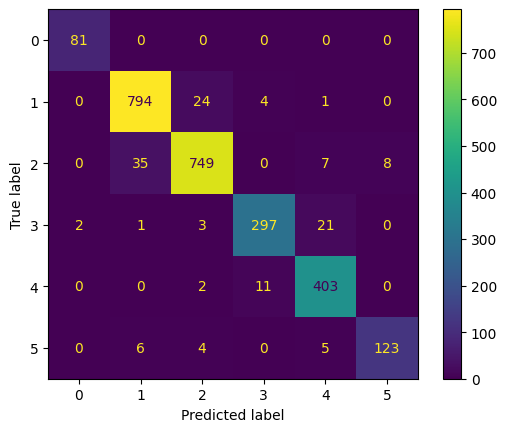

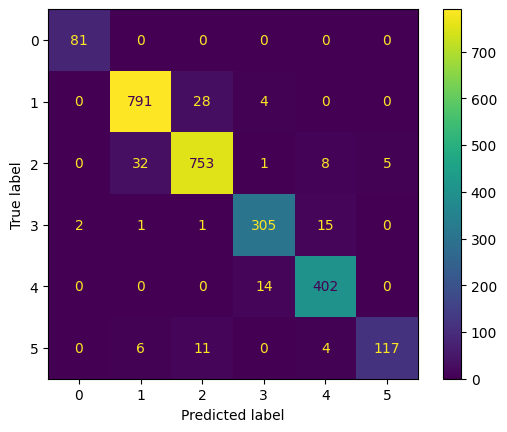

In [9]:

# Extract features for each training point at pixel level
print("\nExtracting features for training points...")
# Feature names for reference
feature_names = [
    'blue_b2', 'green_b3', 'red_b4', 'nir_b8','swir',
    'ndvi', 'gci', 'npci', 'gndvi', 'msavi','vv','vh','vv_vh_ratio'
]
X = []
y = []

for idx, row in tqdm(gdf.iterrows(), total=len(gdf)):
    coords = row.geometry.centroid
    features = extract_features(coords, image_path)
    X.append(features)
    y.append(row[label_column])

# Convert to numpy arrays properly
X = np.vstack(X)
y = np.array([int(cls) - 1 for cls in y])

# Verify the unique classes
unique_classes = np.unique(y)
print("Adjusted class labels:", unique_classes)


# Print feature statistics
print("\nFeature statistics:")
feature_df = pd.DataFrame(X, columns=feature_names)
feature_stats = feature_df.describe()
# print(feature_df)
print(feature_stats)

# Save feature statistics to CSV
feature_stats.to_csv(f'{output_dir}feature_statistics.csv')

# Print class distribution
print("\nClass distribution in training data:")
unique, counts = np.unique(y, return_counts=True)
for cls, cnt in zip(unique, counts):
    print(f"Class {cls}: {cnt} samples")



scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

joblib.dump(scaler, f'{output_dir}standard_scaler.joblib')

# Convert your original labels first
y_consecutive, label_mapping = create_consecutive_labels(y)

# split the data ( stratified sampling )
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_consecutive, test_size=0.3, random_state=42, stratify=y_consecutive,)


print(f"\nTraining samples: {len(X_train)}")
print(f"Testing samples: {len(X_test)}")

classes = np.unique(y)
print("Classes: ",classes)
# Train Random Forest classifier
print("\nTraining Random Forest classifier...")
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, verbose=1, class_weight='balanced')
rf.fit(X_train, y_train)

# Train XGBoost classifier
print("\nTraining XGBoost classifier...")
xgb = XGBClassifier(n_estimators=100, random_state=42, n_jobs=-1, verbosity=1)
xgb.fit(X_train, y_train)

# Feature importance analysis with the new indices
print("\nAnalyzing feature importance with vegetation indices...")

# Random Forest feature importance
rf_importance = rf.feature_importances_
plt.figure(figsize=(10, 6))
plt.barh(feature_names, rf_importance)
plt.title('Random Forest Feature Importance (with Vegetation Indices)')
plt.savefig(f'{output_dir}rf_feature_importance_with_indices.png')
plt.close()

# XGBoost feature importance
xgb_importance = xgb.feature_importances_
plt.figure(figsize=(10, 6))
plt.barh(feature_names, xgb_importance)
plt.title('XGBoost Feature Importance (with Vegetation Indices)')
plt.savefig(f'{output_dir}xgb_feature_importance_with_indices.png')
plt.close()

# Save feature importance to CSV
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'RF_Importance': rf_importance,
    'XGB_Importance': xgb_importance
})
importance_df.to_csv(f'{output_dir}feature_importance_with_indices.csv', index=False)


# Save models
print("\nSaving trained models...")
joblib.dump(rf, f'{output_dir}random_forest_model.joblib')
joblib.dump(xgb, f'{output_dir}xgboost_model.joblib')

# Predict on test data and save
print("\nPredicting on test data...")
test_pred_rf = rf.predict(X_test)
rf_metrics = evaluate_model(y_test, test_pred_rf,
                          model_name='Random Forest',
                          class_names=classes,
                          output_dir='/content/drive/MyDrive/MurangaCropTypeTests/outputs/metrics')
test_pred_xgb = xgb.predict(X_test)
xgb_metrics = evaluate_model(y_test, test_pred_xgb,
                            model_name='XGBoost',
                            class_names=classes,
                            output_dir='/content/drive/MyDrive/MurangaCropTypeTests/outputs/metrics')
# Save test predictions
np.save(f'{output_dir}test_predictions_rf.npy', test_pred_rf)
np.save(f'{output_dir}test_predictions_xgb.npy', test_pred_xgb)




In [10]:
feature_df

,blue_b2,green_b3,red_b4,nir_b8,swir,ndvi,gci,npci,gndvi,msavi,vv,vh,vv_vh_ratio
0,0.08955,0.12670,0.14830,0.29290,0.26955,0.327743,1.311760,0.247004,0.396091,0.210242,0.18955,-8.218450,-0.023064
1,0.02830,0.04295,0.08765,0.13155,0.16475,0.200274,2.062864,0.511859,0.507736,0.073827,0.14910,-8.706052,-0.017126
2,0.02915,0.04980,0.08800,0.19680,0.21710,0.382022,2.951807,0.502347,0.596107,0.179180,0.16870,-9.183583,-0.018370
3,0.02950,0.05120,0.10010,0.18680,0.23500,0.302196,2.648438,0.544753,0.569748,0.140637,0.16410,-5.955624,-0.027554
4,0.03455,0.05670,0.09125,0.22030,0.23440,0.414219,2.885362,0.450715,0.590614,0.209681,0.15800,-6.638153,-0.023802
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8596,0.03660,0.07390,0.05200,0.31630,0.18050,0.717621,3.280108,0.173815,0.621220,0.445159,0.09630,-8.335746,-0.011553
8597,0.02990,0.07680,0.03560,0.44970,0.19130,0.853287,4.855468,0.087023,0.708262,0.678167,0.08630,-6.369573,-0.013549
8598,0.02950,0.06900,0.04020,0.35770,0.15920,0.797939,4.184058,0.153515,0.676588,0.540447,0.07530,-7.885631,-0.009549
8599,0.03560,0.07640,0.05270,0.33040,0.19880,0.724876,3.324607,0.193658,0.624386,0.464116,0.10920,-8.096130,-0.013488


In [11]:
feature_df.head()

,blue_b2,green_b3,red_b4,nir_b8,swir,ndvi,gci,npci,gndvi,msavi,vv,vh,vv_vh_ratio
0,0.08955,0.12670,0.14830,0.29290,0.26955,0.327743,1.311760,0.247004,0.396091,0.210242,0.18955,-8.218450,-0.023064
1,0.02830,0.04295,0.08765,0.13155,0.16475,0.200274,2.062864,0.511859,0.507736,0.073827,0.14910,-8.706052,-0.017126
2,0.02915,0.04980,0.08800,0.19680,0.21710,0.382022,2.951807,0.502347,0.596107,0.179180,0.16870,-9.183583,-0.018370
3,0.02950,0.05120,0.10010,0.18680,0.23500,0.302196,2.648438,0.544753,0.569748,0.140637,0.16410,-5.955624,-0.027554
4,0.03455,0.05670,0.09125,0.22030,0.23440,0.414219,2.885362,0.450715,0.590614,0.209681,0.15800,-6.638153,-0.023802


In [12]:
def calculate_pixel_features(pixels):
            features = []
            band_indices = BAND_INDICES

            for pixel in pixels:
                # Only discard true nodata
                if np.all(np.isnan(pixel)) or np.all(pixel == 0):
                    features.append([np.nan] * 13)
                    continue

                # Extract bands
                blue = pixel[band_indices['blue'] - 1]
                green = pixel[band_indices['green'] - 1]
                red = pixel[band_indices['red'] - 1]
                nir = pixel[band_indices['nir'] - 1]
                swir = pixel[band_indices['swir'] - 1]

                # SAR handling: Convert dB to linear without arbitrary threshold
                vv_db = pixel[band_indices['vv'] - 1]
                vh_db = pixel[band_indices['vh'] - 1]

                # Handle potential infinite values after conversion from -inf dB
                vv = 10 ** (vv_db / 10)
                vh = 10 ** (vh_db / 10)


                vv = np.where(np.isinf(vv), 1e-6, vv)
                vh = np.where(np.isinf(vh), 1e-6, vh)


                vv = np.nan_to_num(vv, nan=1e-6)
                vh = np.nan_to_num(vh, nan=1e-6)


                # Calculate indices
                eps = 1e-10
                ndvi = (nir - red) / (nir + red + eps)
                gci = (nir / (green + eps)) - 1
                npci = (red - blue) / (red + blue + eps)
                gndvi = (nir - green) / (nir + green + eps)
                a = 2 * nir + 1
                msavi = (a - np.sqrt(max(a**2 - 8 * (nir - red), 0))) / 2
                ratio = vv / vh if vh > 1e-6 else 1e6  # Safe division

                features.append([blue, green, red, nir, swir, ndvi, gci, npci, gndvi, msavi, vv, vh, ratio])

            return np.array(features)

In [13]:
# Function to perform the prediction

def predict_image_tiled(model, scaler_path, reference_raster_path, output_path, tile_size=256):
            """
            Memory-safe prediction by processing the image in tiles.
            """
            scaler = joblib.load(scaler_path)

            with rasterio.open(reference_raster_path) as src:
                profile = src.profile.copy()
                profile.update(dtype='uint8', count=1, compress='lzw', nodata=255)
                height, width = src.shape

                with rasterio.open(output_path, 'w', **profile) as dst:
                    for i in tqdm(range(0, height, tile_size), desc="Processing rows"):
                        for j in range(0, width, tile_size):
                            w = min(tile_size, width - j)
                            h = min(tile_size, height - i)
                            window = Window(j, i, w, h)

                            tile_data = src.read(window=window)

                            # Check for true nodata in all bands of the input tile
                            # Assuming nodata in input means all bands are nodata or 0
                            if np.all(tile_data == src.nodata) or np.all(tile_data == 0):
                                # Write the chosen nodata value to the output tile
                                dst.write(np.full((1, h, w), profile['nodata'], dtype=profile['dtype']), window=window)
                                continue

                            pixels = tile_data.reshape(tile_data.shape[0], -1).T
                            features = calculate_pixel_features(pixels) # Make sure this uses the updated function

                            valid_mask = ~np.isnan(features).any(axis=1)
                            if np.any(valid_mask):
                                features_scaled = scaler.transform(features[valid_mask])
                                preds = model.predict(features_scaled)

                                output_tile = np.full(h * w, profile['nodata'], dtype=profile['dtype']) # Initialize with nodata
                                output_tile[valid_mask] = preds
                                output_tile = output_tile.reshape(1, h, w)

                                dst.write(output_tile, window=window)
                            else:
                                # If no valid pixels in the tile, write nodata for the whole tile
                                dst.write(np.full((1, h, w), profile['nodata'], dtype=profile['dtype']), window=window)

In [ ]:

# Load models
rf = joblib.load("/content/drive/MyDrive/MurangaCropTypeTests/outputsrandom_forest_model.joblib")
xgb = joblib.load("/content/drive/MyDrive/MurangaCropTypeTests/outputsxgboost_model.joblib")

# Predict and save
predict_image_tiled(
    model=rf,
    scaler_path="/content/drive/MyDrive/MurangaCropTypeTests/outputsstandard_scaler.joblib",
    reference_raster_path="/content/drive/MyDrive/MurangaImage/MurangaImagefull.tif",
    output_path="/content/drive/MyDrive/MurangaCropTypeTests/outputs/rf_classification_new.tif",
)

predict_image_tiled(
    model=xgb,
    scaler_path="/content/drive/MyDrive/MurangaCropTypeTests/outputsstandard_scaler.joblib",
    reference_raster_path="/content/drive/MyDrive/MurangaImage/MurangaImagefull.tif",
    output_path="/content/drive/MyDrive/MurangaCropTypeTests/outputs/xgb_classification_new.tif",
)


Processing rows:   0%|          | 0/26 [00:00<?, ?it/s][Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: